In [1]:
import torch
import numpy as np
import pyvista as pv
import Ofpp
from utils.visualizer import *
pv.set_jupyter_backend('static') 

In [2]:
# Read in Mesh in VTK
L=1
dir = r'C:\Users\Noahc\Downloads\c5_test\case.foam'
vtk_file_reader = pv.POpenFOAMReader(dir)
vtk_file_reader.set_active_time_value(vtk_file_reader.time_values[-1])
vtk_file_reader.cell_to_point_creation = False
vtk_file_reader.enable_all_patch_arrays()
mesh = vtk_file_reader.read()[0].scale(1/L)

# Mesh readily available components
points = np.array(mesh.points)
n_cells = mesh.n_cells
cell_coords = mesh.cell_centers().points
#dim = detect_dimension(cell_coords)
mesh = mesh.compute_cell_sizes()
cell_volume = mesh["Volume"]

In [3]:
import sys
import os
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.utils.mesh_utils import *

faces_dict = {}
owner = []
neighbour = []
face_areas = []
face_normals = []
face_centres = []

# For each cell, get faces, then for each face get points and calculate area/normals
for cell_id in range(n_cells):
    vtk_cell = mesh.GetCell(cell_id)
    n_faces = vtk_cell.GetNumberOfFaces()

    for face_id in range(n_faces):
        face = vtk_cell.GetFace(face_id)
        face_points = [face.GetPointId(i) for i in range(face.GetNumberOfPoints())]
        face_key = tuple(sorted(face_points))

        if face_key not in faces_dict:
            faces_dict[face_key] = len(owner)
            owner.append(cell_id)
            face_centres.append(points[face_points,:].mean(axis=0))
            neighbour.append(-1)
            face_areas.append(compute_face_area(face_points, points))
            face_normals.append(compute_face_normal(face_points, points))
        else:
            idx = faces_dict[face_key]
            neighbour[idx] = cell_id

unique_faces = list(faces_dict.keys())

# get boundary index
boundary_faces_idx = np.where(np.array(neighbour) == -1)[0]
internal_faces_idx = np.where(np.array(neighbour) != -1)[0]

# convert to numpy
owner          = np.array(owner)
neighbour      = np.array(neighbour)
face_normals   = np.array(face_normals)
face_areas     = np.array(face_areas)
cell_volume    = np.array(cell_volume)

The `owner` vs `torch owner` are different

In [4]:
of_cell_coords = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_new_30\30\C')

In [5]:
meshOfpp = Ofpp.FoamMesh(r'C:\Users\Noahc\Downloads\c5_test')
meshOfpp.read_cell_centres(r'C:\Users\Noahc\Downloads\c5_new_30\30\C')

In [6]:
owner_dif = np.abs(meshOfpp.owner - owner)
indices = np.where(owner_dif > 0.00001)[0]
for i in [int(i) for i in indices]:
    print(f'idx {i}: OF {meshOfpp.owner[i]} and torchVFM {owner[i]}')
    break

idx 3: OF 1 and torchVFM 0


In [7]:
coords_dif = np.abs(meshOfpp.cell_centres - cell_coords)
indices = np.where(coords_dif > 0.00001)[0]
print(len(indices))
for i, idx in enumerate([int(i) for i in indices]):
    print(f'idx {idx}: OF {meshOfpp.cell_centres[idx]} and torchVFM {cell_coords[idx]}')
    if i > 10: break

8448
idx 0: OF [0.7020078  0.75945223 0.        ] and torchVFM [0.70175424 0.75916006 0.        ]
idx 0: OF [0.7020078  0.75945223 0.        ] and torchVFM [0.70175424 0.75916006 0.        ]
idx 1: OF [0.74983508 0.81120497 0.        ] and torchVFM [0.7495797  0.81091082 0.        ]
idx 1: OF [0.74983508 0.81120497 0.        ] and torchVFM [0.7495797  0.81091082 0.        ]
idx 2: OF [7.9943982e-01 8.6488106e-01 4.3102182e-17] and torchVFM [0.79918209 0.86458439 0.        ]
idx 2: OF [7.9943982e-01 8.6488106e-01 4.3102182e-17] and torchVFM [0.79918209 0.86458439 0.        ]
idx 3: OF [0.85088802 0.92055192 0.        ] and torchVFM [0.85062748 0.9202522  0.        ]
idx 3: OF [0.85088802 0.92055192 0.        ] and torchVFM [0.85062748 0.9202522  0.        ]
idx 4: OF [ 9.0424813e-01  9.7829160e-01 -1.7996163e-17] and torchVFM [0.90398432 0.97798836 0.        ]
idx 4: OF [ 9.0424813e-01  9.7829160e-01 -1.7996163e-17] and torchVFM [0.90398432 0.97798836 0.        ]
idx 5: OF [0.95959115 1

The order of the cells are all different, compared to the openfoam

In [8]:
points_dif = np.abs(meshOfpp.points - points)
indices = np.where(points_dif > 0.00001)

`mesh.points` is equal to `points` (in terms of order)

## Fixes for analysis:
Lets try and rearrange so that when we do Torch FVM the cells are all aligned

In [9]:
cell_points = []
for cell_id in range(n_cells):
    cell = mesh.GetCell(cell_id)
    point_ids = [cell.GetPointId(i) for i in range(cell.GetNumberOfPoints())]
    cell_points.append(point_ids)

In [10]:
torch_sorted_faces = np.array([np.sort(face) for face in list(faces_dict.keys())])

In [11]:
Ofpp_sorted_faces = np.array([np.sort(face) for face in meshOfpp.faces])

In [12]:
def reorder_B_to_match_A(A, B):
    # Build a mapping from tuple(row) in B to its index
    row_to_index = {tuple(row): i for i, row in enumerate(B)}

    # Use this mapping to reorder B
    indices = [row_to_index[tuple(row)] for row in A]

    # Reorder B accordingly
    return indices

# Example usage
indices_reorder = reorder_B_to_match_A(Ofpp_sorted_faces, torch_sorted_faces)

In [13]:
Sf_gt = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_new_30\constant\polyMesh\S')
print(Sf_gt.shape, face_areas[indices_reorder].shape)
Sf_gt_mag = np.linalg.norm(Sf_gt, axis=-1)
Sf_dif = Sf_gt_mag - face_areas[indices_reorder][:18180]

(18180, 3) (37020,)


In [14]:
ofpp_normal_vector = Sf_gt/Sf_gt_mag[:,None]

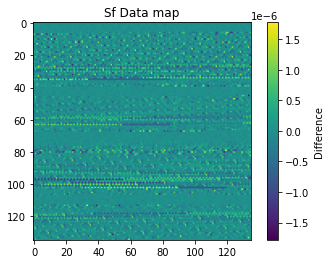

In [15]:
import matplotlib.pyplot as plt
Sf_dif = torch.nn.functional.pad(input=torch.tensor(Sf_dif), pad=(0, 45), mode='constant', value=0)
Sf_dif = Sf_dif.reshape(135,135)
plt.imshow(Sf_dif, cmap='viridis')
plt.colorbar(label='Difference')
plt.title('Sf Data map')
plt.show()

Now for face normals

In [16]:
normal_vector_dif = ofpp_normal_vector - face_normals[indices_reorder,:][:18180,:]

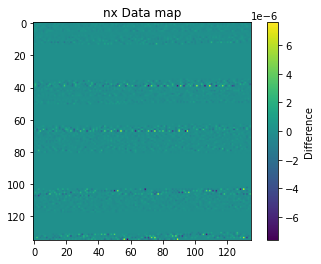

In [17]:
import matplotlib.pyplot as plt
Sf_dif = torch.nn.functional.pad(input=torch.tensor(normal_vector_dif), pad=(0,0,0, 45), mode='constant', value=0)
Sf_dif = Sf_dif.reshape(135,135, 3)
plt.imshow(Sf_dif[...,0], cmap='viridis')
plt.colorbar(label='Difference')
plt.title('nx Data map')
plt.show()

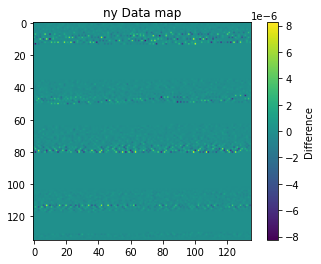

In [18]:
plt.imshow(Sf_dif[...,1], cmap='viridis')
plt.colorbar(label='Difference')
plt.title('ny Data map')
plt.show()

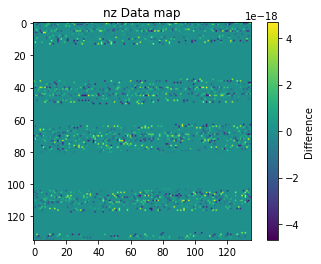

In [19]:
plt.imshow(Sf_dif[...,2], cmap='viridis')
plt.colorbar(label='Difference')
plt.title('nz Data map')
plt.show()

compare owner lists now

In [20]:
owner_dif = np.abs(meshOfpp.owner - owner[indices_reorder])
indices = np.where(owner_dif > 0.00001)[0]
for i in [int(i) for i in indices]:
    print(f'idx {i}: OF {meshOfpp.owner[i]} and torchVFM {owner[indices_reorder][i]}')
    break

owners are the same

In [21]:
neighbour_dif = np.abs(meshOfpp.neighbour[:18180] - neighbour[indices_reorder][:18180])
indices = np.where(neighbour_dif > 0.00001)[0]
for i in [int(i) for i in indices]:
    print(f'idx {i}: OF {meshOfpp.neighbour[i]} and torchVFM {neighbour[indices_reorder][:18180][i]}')
    break

Neighbours are the same

Currently with the face reorder we have proven that:
1. neighbours are the same
2. normal vectors are the same
3. areas are the same
4. owners are the same
5. with cell orders, volume is the same

Its the cell centres that are different

In [22]:
def tetra_volume(a, b, c, d):
    return np.abs(np.dot(np.cross(b - a, c - a), d - a)) / 6.0

def tetra_centroid(a, b, c, d):
    return (a + b + c + d) / 4.0

def true_centroid_for_vtk_hexahedron(mesh, cell_id):
    cell = mesh.GetCell(cell_id)
    point_ids = [cell.GetPointId(i) for i in range(cell.GetNumberOfPoints())]
    points = np.array([mesh.GetPoint(pid) for pid in point_ids])

    # Hexahedron decomposition into 5 tetrahedra (there are multiple valid ways)
    # Each row defines a tetrahedron by indices into the `points` array
    tetrahedra = [
        [0, 1, 3, 4],
        [1, 2, 3, 6],
        [1, 4, 5, 6],
        [3, 4, 6, 7],
        [1, 3, 4, 6],
    ]

    volumes = []
    centroids = []

    for tet in tetrahedra:
        a, b, c, d = [points[i] for i in tet]
        vol = tetra_volume(a, b, c, d)
        centroid = tetra_centroid(a, b, c, d)
        volumes.append(vol)
        centroids.append(centroid)

    volumes = np.array(volumes)
    centroids = np.array(centroids)
    total_volume = np.sum(volumes)

    if total_volume == 0:
        return np.mean(points, axis=0)  # fallback: average of corners
    else:
        return np.average(centroids, axis=0, weights=volumes)

In [23]:
cell_centres = []
for i in range(n_cells):
    cell_centres.append(true_centroid_for_vtk_hexahedron(mesh, i))

In [24]:
print(np.array(cell_centres).min(), np.array(cell_centres).max())

-19.372791232198285 29.42194653792687


In [25]:
coords_dif = np.abs(meshOfpp.cell_centres - cell_coords)
indices = np.where(coords_dif > 0.00001)[0]
print(len(indices))
for i, idx in enumerate([int(i) for i in indices]):
    print(f'idx {idx}: OF {meshOfpp.cell_centres[idx]} and torchVFM {cell_coords[idx]} and new {np.array(cell_centres)[idx]}')
    if i > 10: break

8448
idx 0: OF [0.7020078  0.75945223 0.        ] and torchVFM [0.70175424 0.75916006 0.        ] and new [0.70200782 0.75945223 0.        ]
idx 0: OF [0.7020078  0.75945223 0.        ] and torchVFM [0.70175424 0.75916006 0.        ] and new [0.70200782 0.75945223 0.        ]
idx 1: OF [0.74983508 0.81120497 0.        ] and torchVFM [0.7495797  0.81091082 0.        ] and new [ 7.49835097e-01  8.11204970e-01 -8.70483127e-18]
idx 1: OF [0.74983508 0.81120497 0.        ] and torchVFM [0.7495797  0.81091082 0.        ] and new [ 7.49835097e-01  8.11204970e-01 -8.70483127e-18]
idx 2: OF [7.9943982e-01 8.6488106e-01 4.3102182e-17] and torchVFM [0.79918209 0.86458439 0.        ] and new [0.79943982 0.86488106 0.        ]
idx 2: OF [7.9943982e-01 8.6488106e-01 4.3102182e-17] and torchVFM [0.79918209 0.86458439 0.        ] and new [0.79943982 0.86488106 0.        ]
idx 3: OF [0.85088802 0.92055192 0.        ] and torchVFM [0.85062748 0.9202522  0.        ] and new [0.85088802 0.92055191 0.     

In [26]:
coords_dif = np.abs(meshOfpp.cell_centres - cell_centres)
indices = np.where(coords_dif > 0.00001)[0]
print(len(indices))
for i, idx in enumerate([int(i) for i in indices]):
    print(f'idx {idx}: OF {meshOfpp.cell_centres[idx]} and torchVFM {cell_coords[idx]} and new {np.array(cell_centres)[idx]}')
    if i > 10: break

0


so now we have cell_coordinates matching too

# Lets match Phi

In [27]:
from src.gauss_green import gaus_green_vfm_mesh
from grad_comparison import my_cylinder_case
green_mesh = gaus_green_vfm_mesh(vtk_file_reader)
U_bc_dict, p_bc_dict = my_cylinder_case()
bc_dict = {'U': U_bc_dict,
            'p': p_bc_dict}
green_mesh.add_bc_conditions(bc_dict)
green_mesh.patch_face_keys_dict()

field = torch.tensor(green_mesh.mesh['U'],dtype=torch.float64).unsqueeze(0)[...,:2]
field.shape
#phi = mesh.compute_phi(field) # 18180 faces 18225 square (pad by 45)
# phi = torch.nn.functional.pad(input=phi, pad=(0, 45), mode='constant', value=0)
# phi = phi.reshape(135,135)

div_field, lap_field, phi = green_mesh.compute_everything(field)

Excluding Z-dim in mesh
2
Calculating Cell2Cell at Face Linear Interpolation Weights (L2):
  min w:0.4621,               max w:0.5837,               mean w:0.5050
Assessing Linear Intercept Skew From Face Centroid:
 TBD...
Collocating Boundary Patches to Cell Faces
 Found Patch "out" with 80 Faces
 Found Patch "sym1" with 100 Faces
 Found Patch "sym2" with 100 Faces
 Found Patch "in" with 80 Faces
 Found Patch "cylinder" with 80 Faces
Excluding Z-axis patch back
Excluding Z-axis patch front


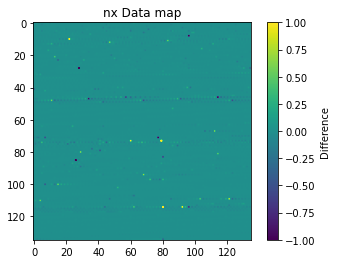

In [28]:
phi_gt = torch.tensor(Ofpp.parse_field_all(r'C:\Users\Noahc\Downloads\c5_test\30.3\phi')[0])
phi_dif = phi_gt - phi.squeeze(0).squeeze(0)[indices_reorder][:18180]#[green_mesh.internal_faces_idx]

phi_dif_mapped = torch.nn.functional.pad(input=(phi_dif/phi_gt), pad=(0, 45), mode='constant', value=0)
phi_dif_mapped = phi_dif_mapped.reshape(135,135)
plt.imshow(phi_dif_mapped, cmap='viridis', vmin=-1.0, vmax=1.0)
plt.colorbar(label='Difference')
plt.title('nx Data map')
plt.show()

In [29]:
U = Ofpp.parse_field_all(r'C:\Users\Noahc\Downloads\c5_test\30.3\U')[0][:,:2]

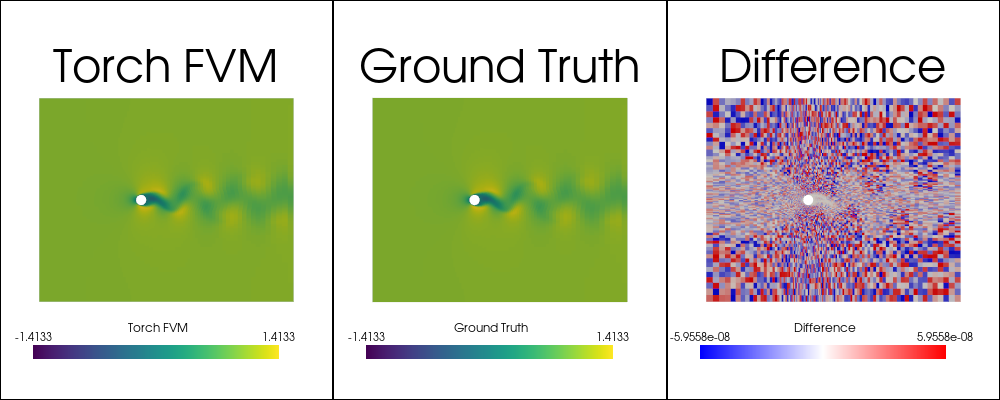

In [30]:
plot_comparison(green_mesh.mesh, None, f'Phi Difference',
                    prediction=field.squeeze(0).numpy(),
                    ground_truth = U,
                    i=0, interactive = True)

In [31]:
div_field.shape

torch.Size([1, 1, 9200, 2])

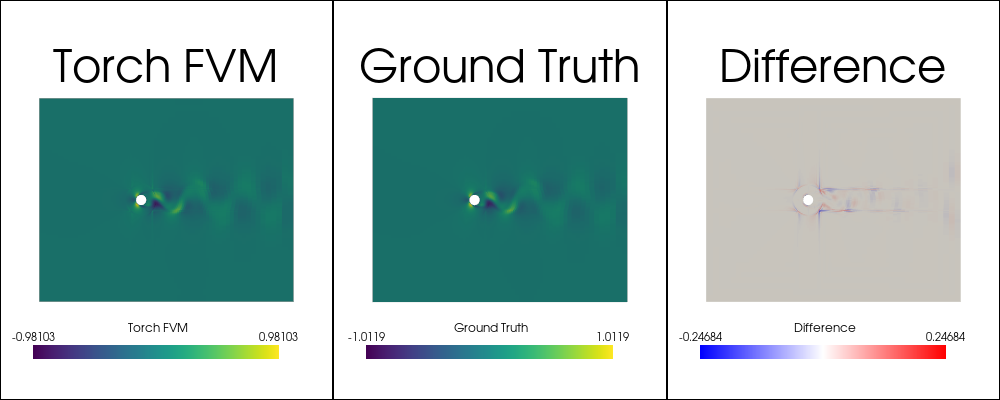

In [32]:
div_field_gt = Ofpp.parse_field_all(r'C:\Users\Noahc\Downloads\c5_test\30.3\divU')[0]
plot_comparison(green_mesh.mesh, None, f'diverge Difference',
                    prediction=div_field.squeeze(0).squeeze(0).numpy(),
                    ground_truth = div_field_gt,
                    i=0, interactive = True)

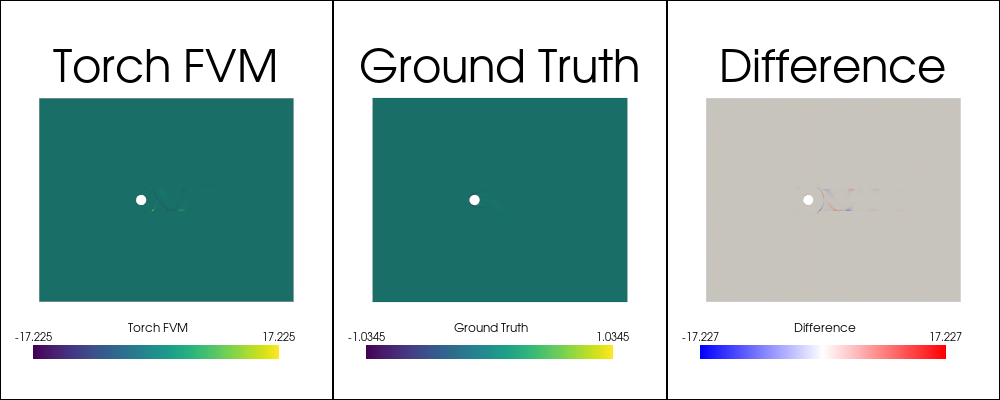

In [33]:
lap_field_gt = Ofpp.parse_field_all(r'C:\Users\Noahc\Downloads\c5_test\30.3\lapU')[0]
plot_comparison(green_mesh.mesh, None, f'laplace Difference',
                    prediction=lap_field.squeeze(0).squeeze(0).numpy()*0.01333333,
                    ground_truth = lap_field_gt,
                    i=0, interactive = True)

Lets try accumulating the geometry

In [34]:
green_mesh.Sf.shape

torch.Size([1, 37020, 2])

In [35]:
green_mesh.Sf.shape

torch.Size([1, 37020, 2])

In [37]:
sf_field = torch.zeros((n_cells, 2),dtype=torch.float64)

face_field = green_mesh.Sf.squeeze(0)

idx = green_mesh.internal_faces_idx
sf_field.index_add_(0, green_mesh.owner[idx], face_field[idx,:])
sf_field.index_add_(0, green_mesh.neighbour[idx], -face_field[idx,:])

tensor([[ 5.3299e-02,  5.7659e-02],
        [-1.1629e-09,  4.2926e-09],
        [ 6.8007e-10, -5.2041e-09],
        ...,
        [-9.1172e-08,  7.2129e-09],
        [-1.4805e-08, -2.5478e-09],
        [ 7.2852e-09,  2.1213e-01]], dtype=torch.float64)

In [ ]:
Sf_gt.shape

(18180, 3)

In [40]:
for i in range(10):
    print(f'{Sf_gt[i,0]} vs {green_mesh.Sf.squeeze(0)[indices_reorder,:][i,0]}')

0.05709183 vs 0.05709177093908412
-0.052703204 vs -0.052703199967947124
0.048910596 vs 0.048910616906770815
0.061025352 vs 0.06102532136675669
-0.054661393 vs -0.05466139309112126
0.050727872 vs 0.05072784150059078
0.065105024 vs 0.06510501863907642
-0.05669234 vs -0.05669236096331089
0.052612668 vs 0.05261266437106615
0.069336276 vs 0.06933623383175683


In [38]:
sf_field_gt = torch.zeros((n_cells, 2),dtype=torch.float64)

face_field = torch.tensor(Sf_gt[...,:2],dtype=torch.float64)

idx = green_mesh.internal_faces_idx
sf_field_gt.index_add_(0, green_mesh.owner[indices_reorder][:18180], face_field)
sf_field_gt.index_add_(0, green_mesh.neighbour[indices_reorder][:18180], -face_field)

tensor([[ 5.3299e-02,  5.7659e-02],
        [ 1.0000e-09, -6.9389e-18],
        [ 0.0000e+00, -1.0000e-09],
        ...,
        [-1.0000e-08,  2.7000e-09],
        [-3.0000e-08, -2.6000e-09],
        [-1.0000e-08,  2.1213e-01]], dtype=torch.float64)

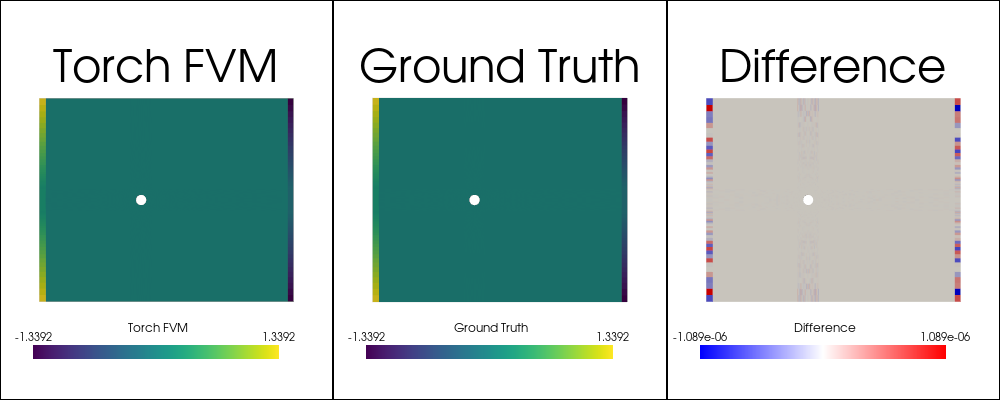

In [39]:
plot_comparison(green_mesh.mesh, None, f'Sf Difference',
                    prediction=sf_field,
                    ground_truth = sf_field_gt,
                    i=0, interactive = True)

Volume

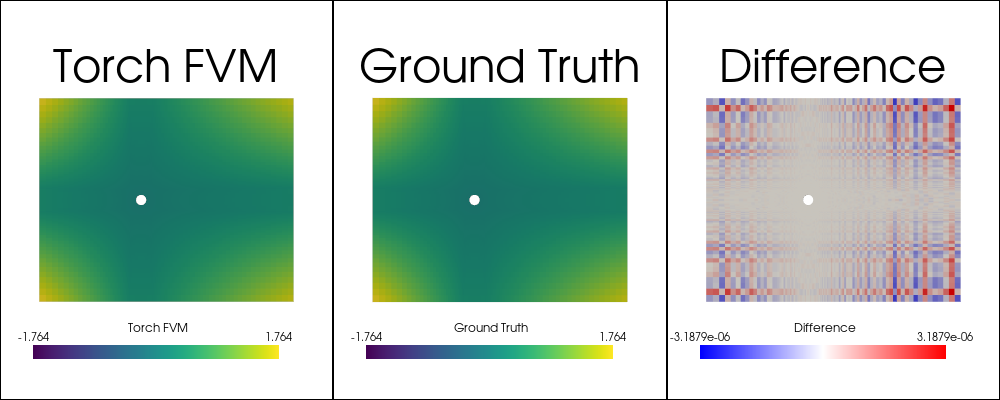

In [56]:
volume_gt = Ofpp.parse_field_all(r'C:\Users\Noahc\Downloads\c5_new_30\30\V')[0]
plot_comparison(green_mesh.mesh, None, f'Sf Difference',
                    prediction=green_mesh.cell_volume[:,None],
                    ground_truth = volume_gt[:,None],
                    i=0, interactive = True)

Lets look at area

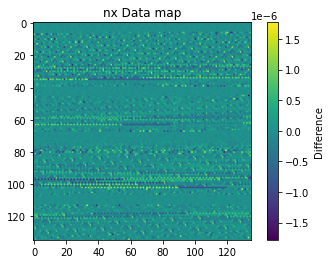

In [50]:
phi_gt = torch.tensor(Ofpp.parse_field_all(r'C:\Users\Noahc\Downloads\c5_test\30.3\magSf')[0])
phi_dif = phi_gt - green_mesh.face_areas[indices_reorder][:18180]#[green_mesh.internal_faces_idx]

phi_dif_mapped = torch.nn.functional.pad(input=phi_dif, pad=(0, 45), mode='constant', value=0)
phi_dif_mapped = phi_dif_mapped.reshape(135,135)
plt.imshow(phi_dif_mapped, cmap='viridis')
plt.colorbar(label='Difference')
plt.title('nx Data map')
plt.show()

In [45]:
green_mesh.face_normals.shape

torch.Size([37020, 2])

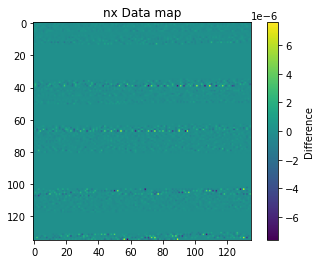

In [51]:
phi_gt = torch.tensor(Ofpp.parse_field_all(r'C:\Users\Noahc\Downloads\c5_test\30.3\n_vec')[0])[...,:2]
phi_dif = phi_gt - green_mesh.face_normals[indices_reorder,:][:18180,:]#[green_mesh.internal_faces_idx]

phi_dif_mapped = torch.nn.functional.pad(input=phi_dif[:,0], pad=(0, 45), mode='constant', value=0)
phi_dif_mapped = phi_dif_mapped.reshape(135,135)
plt.imshow(phi_dif_mapped, cmap='viridis')
plt.colorbar(label='Difference')
plt.title('nx Data map')
plt.show()

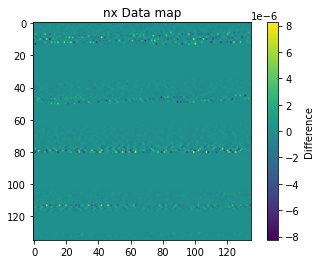

In [52]:
phi_dif_mapped = torch.nn.functional.pad(input=phi_dif[:,1], pad=(0, 45), mode='constant', value=0)
phi_dif_mapped = phi_dif_mapped.reshape(135,135)
plt.imshow(phi_dif_mapped, cmap='viridis')
plt.colorbar(label='Difference')
plt.title('nx Data map')
plt.show()

# Lets try and recreate the divergence using Openfoam Fields only

ignoring boundaries for nowq

In [63]:
owner_new = green_mesh.owner[indices_reorder]
neighbour_new = green_mesh.neighbour[indices_reorder[:18180]]
face_area = Ofpp.parse_field_all(r'C:\Users\Noahc\Downloads\c5_test\30.3\magSf')[0]
face_normals = Ofpp.parse_field_all(r'C:\Users\Noahc\Downloads\c5_test\30.3\n_vec')[0]

In [58]:
field = Ofpp.parse_field_all(r'C:\Users\Noahc\Downloads\c5_test\30.3\U')[0]

In [66]:
green_mesh.interp_ws.shape

torch.Size([1, 1, 37020, 1])

In [70]:
U_f       = torch.zeros(n_faces, 2)
        
U_o = torch.tensor(field[...,owner_new[:18180],:])
U_n = torch.tensor(field[...,neighbour_new,:])
U_f = U_o*green_mesh.interp_ws[0,0,:18180,:] + U_n*(1-green_mesh.interp_ws[0,0,:18180,:])
U_f.shape

torch.Size([18180, 3])

In [71]:
of_Sf = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_new_30\constant\polyMesh\S')
of_Sf.shape

(18180, 3)

In [92]:
phi = torch.einsum('fd,fd->f', torch.tensor(of_Sf), torch.tensor(U_f))
divergence  = phi.unsqueeze(-1) * U_f 
div_field = torch.zeros((n_cells, 3), dtype=divergence.dtype)
div_field.index_add_(0, owner_new[:18180], divergence)
div_field.index_add_(0, neighbour_new[:18180], -divergence)
div_field/volume_gt[:,None]

<ipython-input-92-e331104ffb0c>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.einsum('fd,fd->f', torch.tensor(of_Sf), torch.tensor(U_f))


tensor([[ 1.4783e-03,  3.4590e-04,  3.7953e-20],
        [-4.8773e-03,  5.7541e-03, -1.5317e-19],
        [ 1.2873e-03,  5.4925e-03,  1.1374e-19],
        ...,
        [ 5.4287e-05,  1.8669e-04, -4.6157e-22],
        [-5.7310e-04,  8.1627e-07,  4.5814e-28],
        [-5.3394e-05,  2.7068e-05, -2.3140e-23]], dtype=torch.float64)

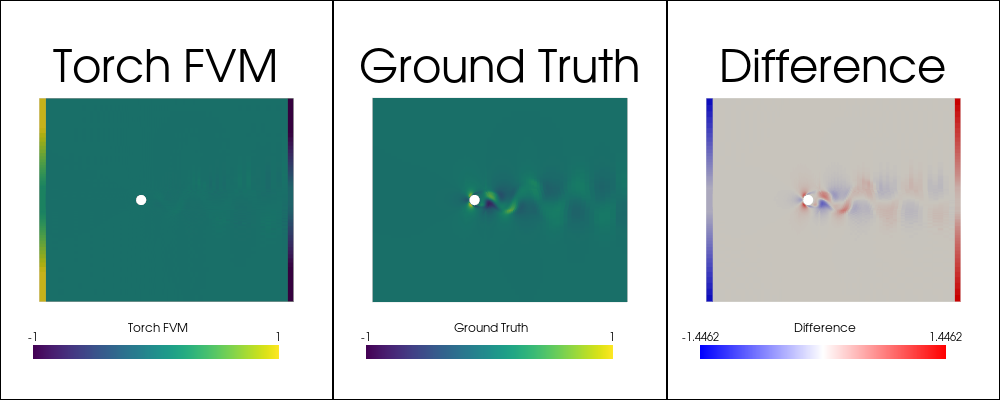

In [93]:
divergence_gt = Ofpp.parse_field_all(r'C:\Users\Noahc\Downloads\c5_test\30.3\divU')[0]
plot_comparison(green_mesh.mesh, None, f'Sf Difference',
                    prediction=div_field.numpy(),
                    ground_truth = divergence_gt,
                    i=0, interactive = True, 
                    clims=[-1,1],
                    clims2=[-1,1],
                    )